In [3]:
# imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage.measure import label, regionprops
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.retinanet import RetinaNet, RetinaNetHead, RetinaNet_ResNet50_FPN_Weights
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.resnet import ResNet50_Weights
from torchvision.transforms import functional

# Question 3

## Mask to Box Functions

Approach for converting the mask to boxes:
- Create a color to label map by observing the dataset (color value was taken using a color picker to get exact value)
- For each label, create a black n white mask only for that feature
- Similar to question 2, get the bounding box using skimage functions label and region props, which look for connected components in images
- Store the annotations in a list of dict format, for each different box, for each image
- The dict is of the form {"label": [coordinates]}

In [4]:
color_label_map = {
    (0, 0, 143): 'background', 
    (0, 32, 255): 'hair', 
    (0, 191, 255): 'face', 
    (96, 255, 159): 'torso', 
    (255, 255, 0): 'legs', 
    (143, 0, 0): 'feet',
    (175, 0, 0): 'feet', 
    (255, 80, 0): 'hands'}

In [5]:
def mask_to_boxes(image, mask):
    if type(image) == str:
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if type(mask) == str:
        mask = cv2.imread(mask)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
    bbox = []
    for color, label_name in color_label_map.items():
        cur_mask = mask.copy()
        cur_mask = cv2.inRange(cur_mask, color, color)
        labels = label(cur_mask)
        props = regionprops(labels)
        for prop in props:
            box = prop.bbox
            bbox.append({label_name: [box[1], box[0], box[3], box[2]]})
        cur_mask = cv2.cvtColor(cur_mask, cv2.COLOR_GRAY2RGB)
    return bbox

## Data Split

In [6]:
imgs = []
masks = []
dataset_path = "datasets/"
dirs = sorted(os.listdir(dataset_path))
for data_dir in dirs:
    dir_masks = sorted([dataset_path + data_dir + "/" + f for f in os.listdir(os.path.join(dataset_path, data_dir)) if f.endswith('.png')])
    dir_imgs = sorted([dataset_path + data_dir + "/" + f for f in os.listdir(os.path.join(dataset_path, data_dir)) if f.endswith('.jpg')])
    masks.extend(dir_masks)
    imgs.extend(dir_imgs)

In [7]:
train_imgs, val_imgs, train_masks, val_masks = train_test_split(imgs, masks, test_size=0.2, random_state=42)

## Dataset Visualization

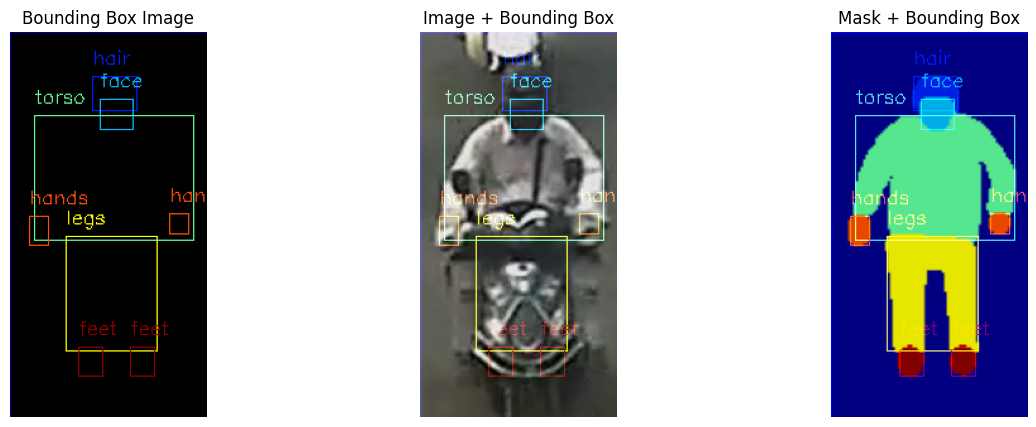

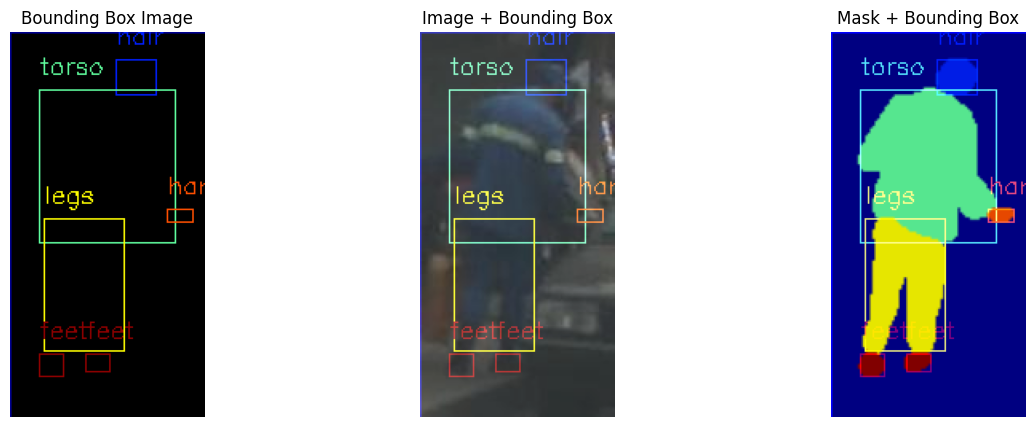

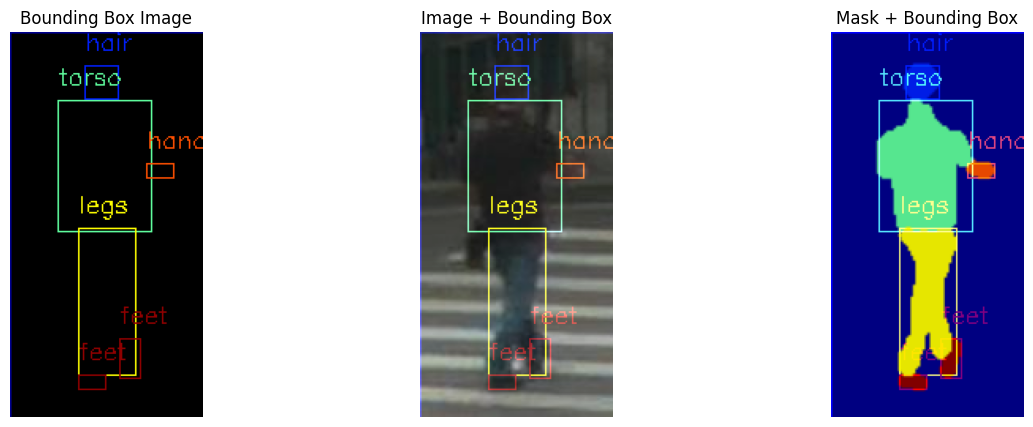

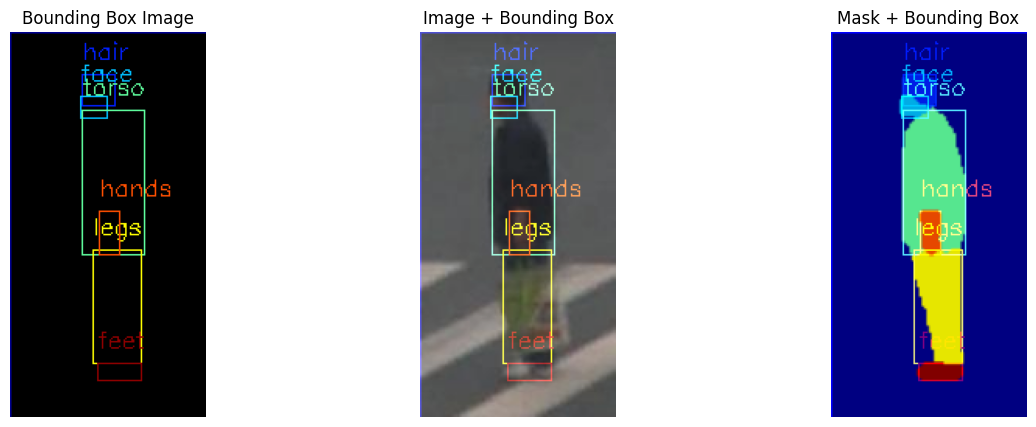

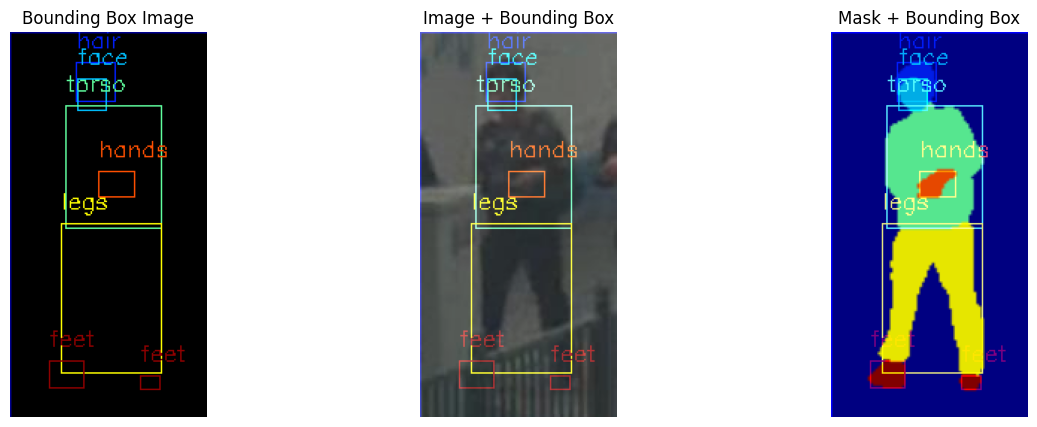

In [8]:
sample_indices = random.sample(range(len(train_imgs)), 5)
sample_train_imgs = [train_imgs[i] for i in sample_indices]
sample_train_masks = [train_masks[i] for i in sample_indices]

for img, mask in zip(sample_train_imgs, sample_train_masks):
    original_img = cv2.imread(img)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    original_mask = cv2.imread(mask)
    original_mask = cv2.cvtColor(original_mask, cv2.COLOR_BGR2RGB)
    bboxes = mask_to_boxes(original_img, original_mask)
    bbox_image = np.zeros_like(original_img, dtype=np.uint8)
    for box in bboxes:
        for label_name, coord in box.items():
            color = [c for c in color_label_map if color_label_map[c] == label_name][0]
            cv2.rectangle(bbox_image, (int(coord[0]), int(coord[1])), (int(coord[2]), int(coord[3])), color, 1)
            cv2.putText(bbox_image, label_name, (int(coord[0]), int(coord[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))


    # Plot bbox_image
    axs[0].imshow(bbox_image)
    axs[0].set_title('Bounding Box Image')
    axs[0].axis('off')

    # Plot original image with bbox_image
    combined_img = cv2.addWeighted(original_img, 0.9, bbox_image, 0.9, 0)
    axs[1].imshow(combined_img)
    axs[1].set_title('Image + Bounding Box')
    axs[1].axis('off')

    # Plot original mask with bbox_image
    original_mask = cv2.resize(original_mask, (bbox_image.shape[1], bbox_image.shape[0]))
    combined_mask = cv2.addWeighted(original_mask, 0.9, bbox_image, 0.9, 0)
    axs[2].imshow(combined_mask)
    axs[2].set_title('Mask + Bounding Box')
    axs[2].axis('off')

    plt.show()

## Dataset Analysis

In [16]:
label_names = ["background", "hair", "face", "torso", "legs", "feet", "hands"]
frequency = {label: 0 for label in label_names}
width = []
height = []
x_center = {label: [] for label in label_names}
y_center = {label: [] for label in label_names}

In [17]:
for img, mask in zip(train_imgs, train_masks):
    bbox = mask_to_boxes(img, mask)
    img_width, img_height = cv2.imread(img).shape[1], cv2.imread(img).shape[0]
    for box in bbox:
        for l, c in box.items():
            frequency[l] += 1
            width.append(c[2] - c[0])
            height.append(c[3] - c[1])
            x_center[l].append((c[0] + c[2]) / (2.0 * img_width))
            y_center[l].append((c[1] + c[3]) / (2.0 * img_height))

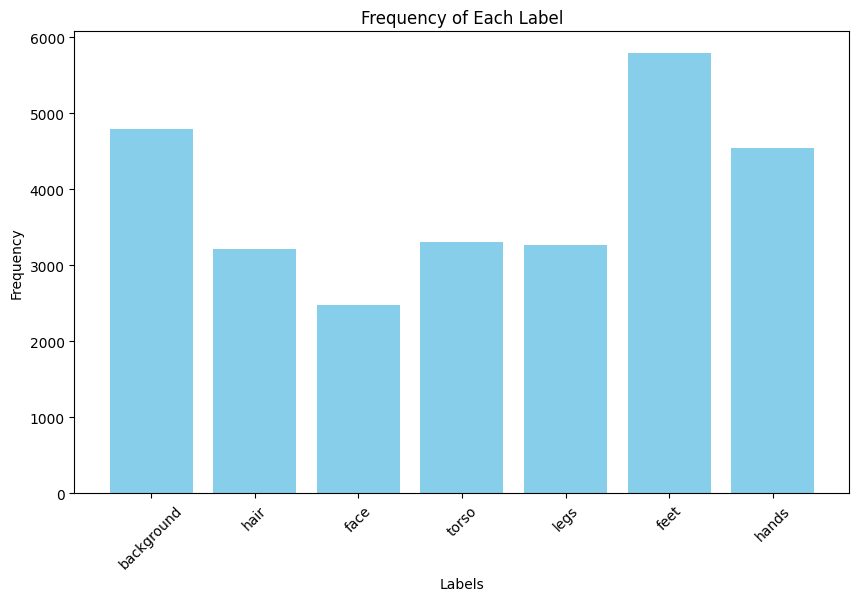

In [18]:
labels = list(frequency.keys())
counts = list(frequency.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Each Label')
plt.xticks(rotation=45)
plt.show()

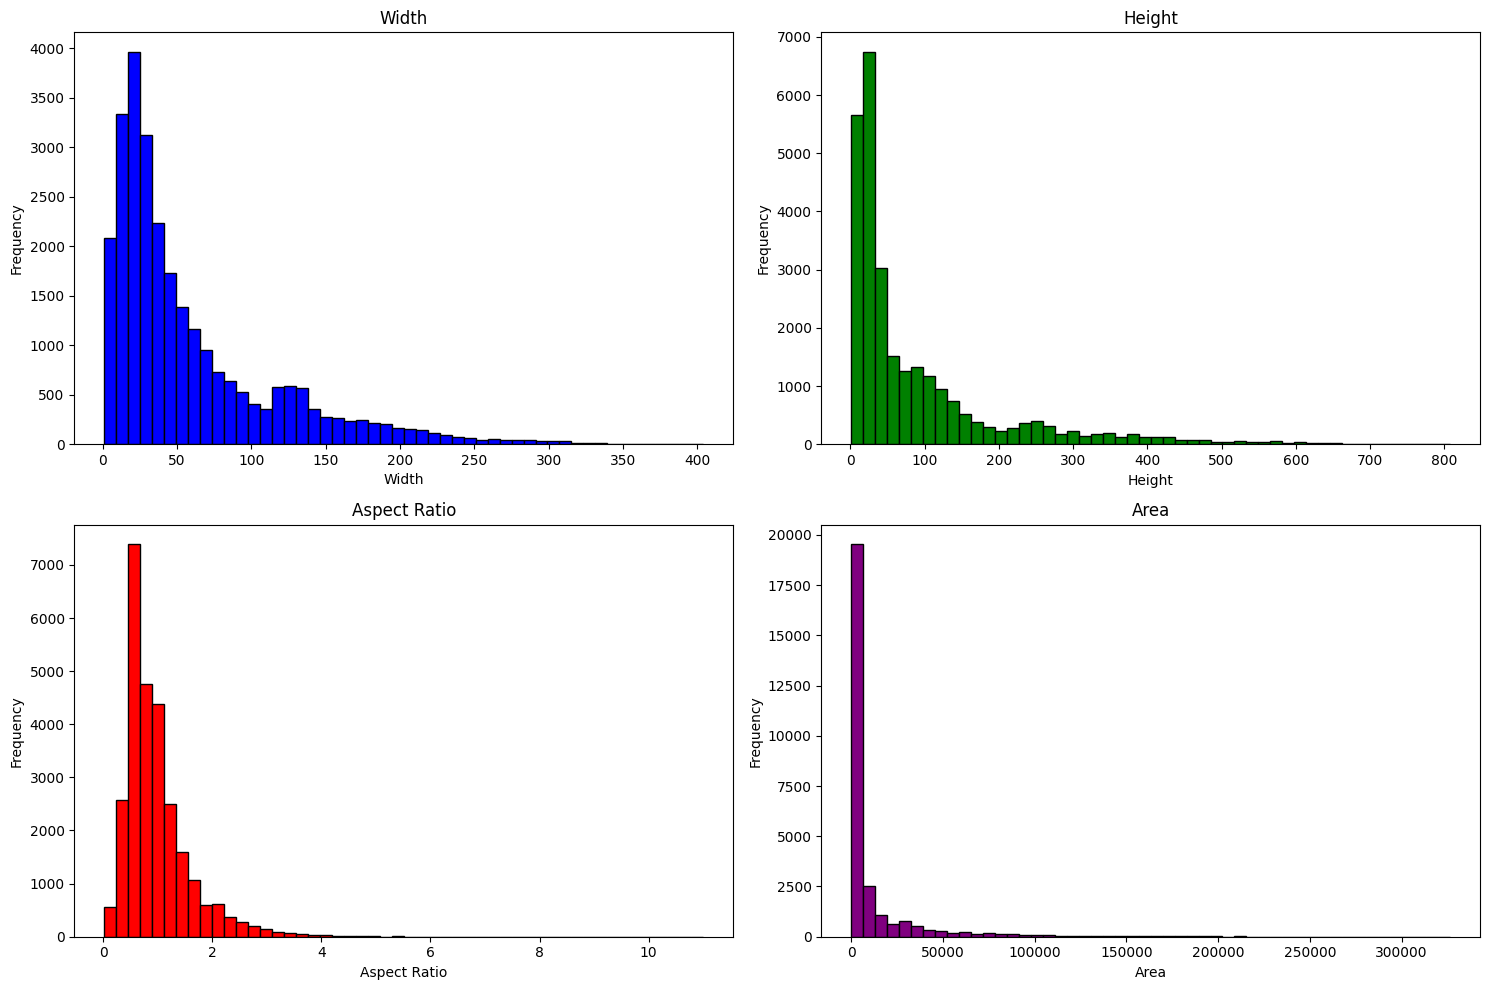

In [19]:
aspect_ratios = [w / h for w, h in zip(width, height)]
areas = [w * h for w, h in zip(width, height)]
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].hist(width, bins=50, color='blue', edgecolor='black')
axs[0, 0].set_title('Width')
axs[0, 0].set_xlabel('Width')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(height, bins=50, color='green', edgecolor='black')
axs[0, 1].set_title('Height')
axs[0, 1].set_xlabel('Height')
axs[0, 1].set_ylabel('Frequency')

axs[1, 0].hist(aspect_ratios, bins=50, color='red', edgecolor='black')
axs[1, 0].set_title('Aspect Ratio')
axs[1, 0].set_xlabel('Aspect Ratio')
axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(areas, bins=50, color='purple', edgecolor='black')
axs[1, 1].set_title('Area')
axs[1, 1].set_xlabel('Area')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

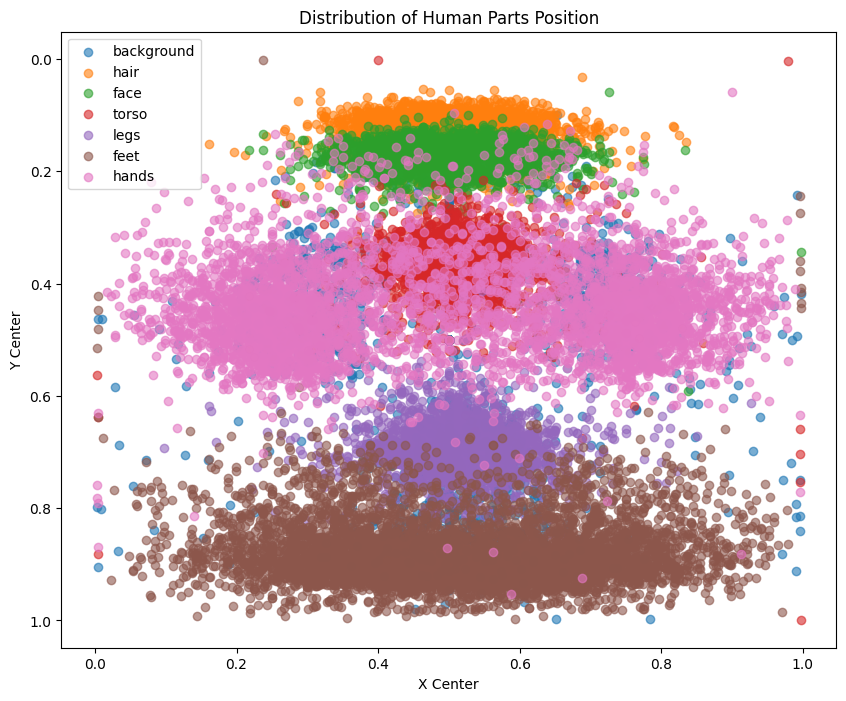

In [21]:
plt.figure(figsize=(10, 8))
for label_name in label_names:
    plt.scatter(x_center[label_name], y_center[label_name], label=label_name, alpha=0.6)

plt.xlabel('X Center')
plt.ylabel('Y Center')
plt.title('Distribution of Human Parts Position')
plt.gca().invert_yaxis()  # Invert the y-axis
plt.legend()
plt.show()

## Dataset and Dataloader

In [7]:
def collate(batch):
    return list(zip(*batch))

In [8]:
id_label_map = {
    "background": 0,
    "hair": 1,
    "face": 2,
    "torso": 3,
    "legs": 4,
    "feet": 5,
    "hands": 6
}

In [9]:
class HumanPartsDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        bboxes = mask_to_boxes(image, mask)
        coords = []
        labels = []
        for box in bboxes:
            for label_name, coord in box.items():
                coords.append(coord)
                labels.append(id_label_map[label_name])
        coords = torch.tensor(coords, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {}
        target["boxes"] = coords
        target["labels"] = labels
        
        image_t = torch.as_tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        if self.transform:
            image_t = self.transform(image_t)
        image_t = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_t)
        
        return image_t, target

In [10]:
train_loader = DataLoader(HumanPartsDataset(train_imgs, train_masks), batch_size=10, shuffle=True, collate_fn=collate)
val_loader = DataLoader(HumanPartsDataset(val_imgs, val_masks), batch_size=5, shuffle=False, collate_fn=collate)

## Model Implementation

In [11]:
model = retinanet_resnet50_fpn(weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT)
in_features = model.head.classification_head.cls_logits.in_channels
num_anchors = model.head.classification_head.num_anchors
num_classes = 7
model.head.classification_head.num_classes = num_classes
model.head.classification_head.cls_logits = nn.Conv2d(in_features, num_anchors * num_classes, kernel_size=3, stride=1, padding=1)

## Training

In [18]:
def train(model, loader, n_epochs=15):
    torch.cuda.empty_cache()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr=0.001, weight_decay=1e-4)
        
    for epoch in range(n_epochs):
        loss_overall = 0
        model.train()
        for images, targets in loader:
            images = [image.to(device) for image in images] 
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_overall += losses.item()
            
            losses.backward()
            optimizer.step()   
            
        print(f"Epoch {epoch+1}, Loss: {loss_overall / len(loader)}")

In [19]:
train(model, train_loader)
torch.save(model.state_dict(), "model.pth")

Epoch 1, Loss: 22.063780842519332
Epoch 2, Loss: 1.0835182708144564
Epoch 3, Loss: 0.9876022227931098
Epoch 4, Loss: 0.9568875670809099
Epoch 5, Loss: 0.9130959736435947
Epoch 6, Loss: 0.880588363585788
Epoch 7, Loss: 0.8594632688380942
Epoch 8, Loss: 0.8411688351480743
Epoch 9, Loss: 0.8262969592016202
Epoch 10, Loss: 0.8115031356315131
Epoch 11, Loss: 0.8009916511995935
Epoch 12, Loss: 0.7874963629508996
Epoch 13, Loss: 0.7787532917332574
Epoch 14, Loss: 0.7667003623694651
Epoch 15, Loss: 0.7610282190966682


## Testing

In [12]:
def test(model, loader, threshold=0.7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    inputs = []
    output = []

    with torch.no_grad():
        for images, targets in loader:
            images = [image.to(device) for image in images] 
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            preds = model(images)
            for pred in preds:
                boxes = []
                for box, score, label in zip(pred["boxes"], pred["scores"], pred["labels"]):
                    if score >= threshold:
                        boxes.append((box, label, score))
                output.append(boxes)
            inputs.extend(images)
    return inputs, output

In [13]:
model.load_state_dict(torch.load("model.pth"))
inputs, preds = test(model, val_loader, 0.5)

In [14]:
box_pred = []
for pred in preds:
    boxes = []
    for box in pred:
        coord = box[0].cpu().detach().numpy()
        score = float(box[2].cpu().detach())
        label_val = int(box[1].cpu().detach())
        label_name = [l for l in id_label_map.keys() if id_label_map[l] == label_val][0]
        boxes.append({label_name: ([int(coord[0]), int(coord[1]), int(coord[2]), int(coord[3])], score)})
    box_pred.append(boxes)

In [15]:
box_gt = []
for vm, vi in zip(val_masks, val_imgs):
    box = mask_to_boxes(vi, vm)
    box_gt.append(box)

## Results Visualization

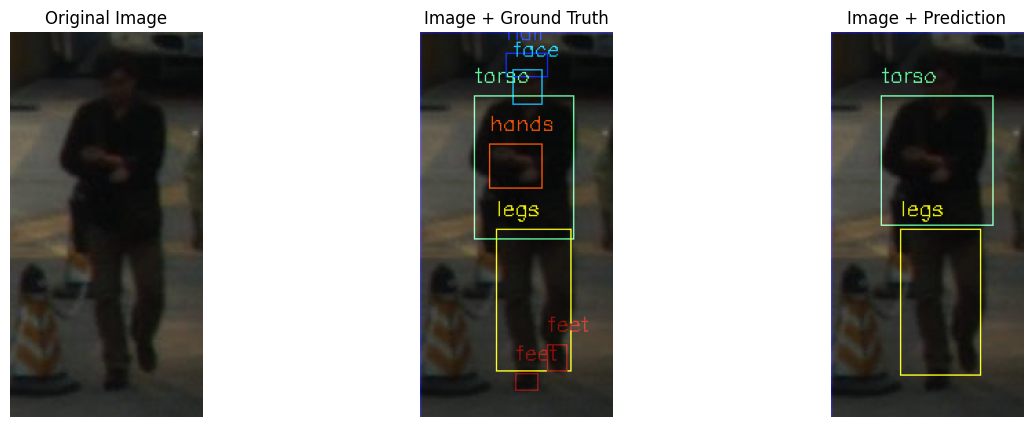

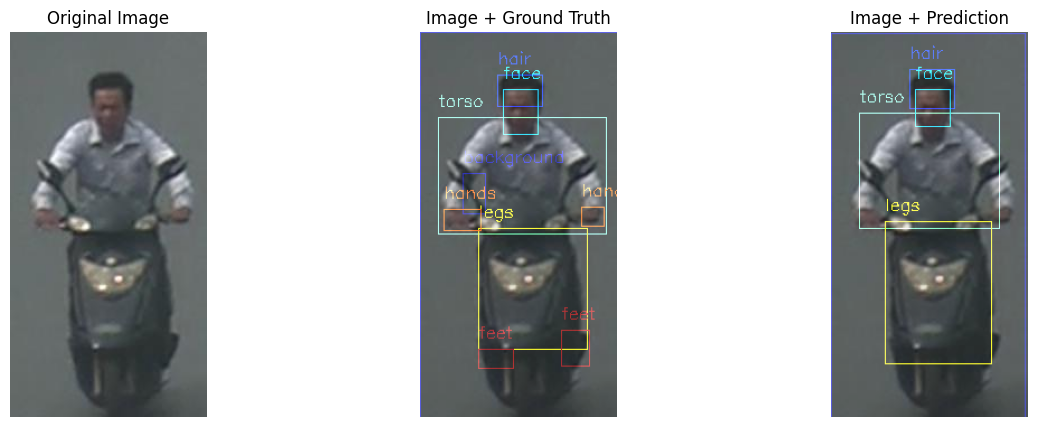

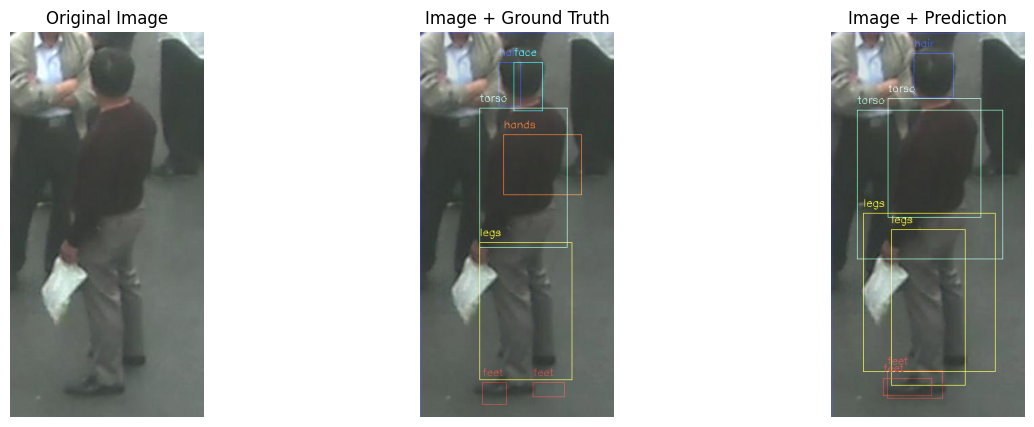

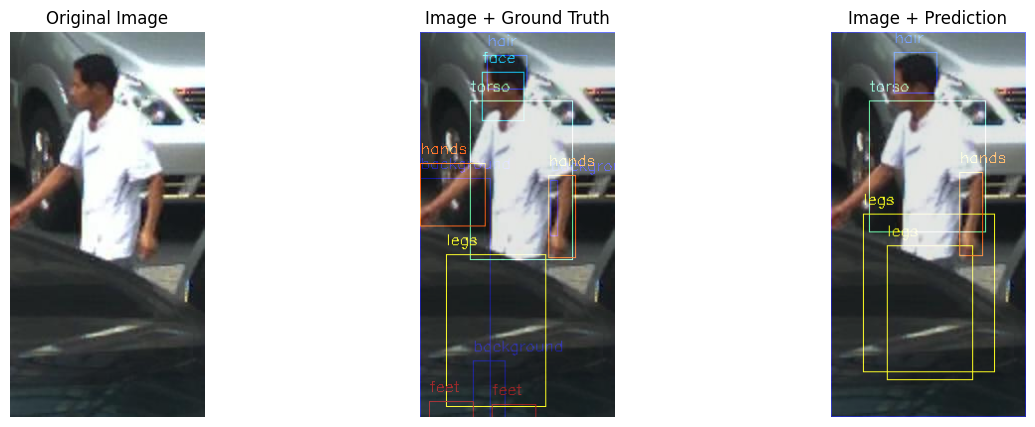

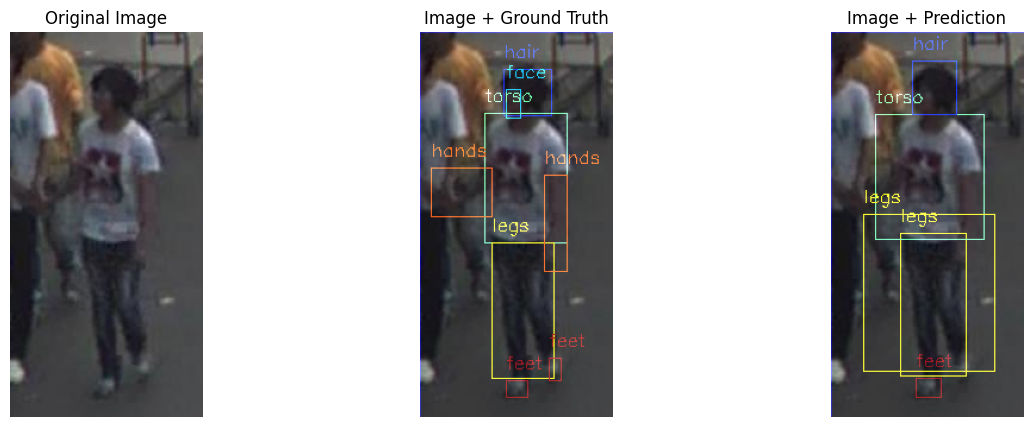

In [16]:
sample_indices = random.sample(range(len(val_imgs)), 5)
sample_val_imgs = [val_imgs[i] for i in sample_indices]
sample_val_mask_gt = [box_gt[i] for i in sample_indices]
sample_val_mask_preds = [box_pred[i] for i in sample_indices]

for img, gt, pred in zip(sample_val_imgs, sample_val_mask_gt, sample_val_mask_preds):
    original_img = cv2.imread(img)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    bbox_gt = np.zeros_like(original_img, dtype=np.uint8)
    bbox_pred = np.zeros_like(original_img, dtype=np.uint8)
    for box in gt:
        for label_name, coord in box.items():
            color = [c for c in color_label_map if color_label_map[c] == label_name][0]
            cv2.rectangle(bbox_gt, (int(coord[0]), int(coord[1])), (int(coord[2]), int(coord[3])), color, 1)
            cv2.putText(bbox_gt, label_name, (int(coord[0]), int(coord[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    for box in pred:
        for label_name, bbox in box.items():
            coord, score = bbox
            color = [c for c in color_label_map if color_label_map[c] == label_name][0]
            cv2.rectangle(bbox_pred, (int(coord[0]), int(coord[1])), (int(coord[2]), int(coord[3])), color, 1)
            cv2.putText(bbox_pred, label_name, (int(coord[0]), int(coord[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))


    axs[0].imshow(original_img)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    img_n_gt = cv2.addWeighted(original_img, 0.9, bbox_gt, 0.9, 0)
    axs[1].imshow(img_n_gt)
    axs[1].set_title('Image + Ground Truth')
    axs[1].axis('off')

    img_n_pred = cv2.addWeighted(original_img, 0.9, bbox_pred, 0.9, 0)
    axs[2].imshow(img_n_pred)
    axs[2].set_title('Image + Prediction')
    axs[2].axis('off')

    plt.show()

## Metrics

In [17]:
def iou(box1, box2):
    tlx1, tly1, brx1, bry1 = box1
    tlx2, tly2, brx2, bry2 = box2

    xi1 = max(tlx1, tlx2)
    yi1 = max(tly1, tly2)
    xi2 = min(brx1, brx2)
    yi2 = min(bry1, bry2)

    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)
    box1_area = (brx1 - tlx1 + 1) * (bry1 - tly1 + 1)
    box2_area = (brx2 - tlx2 + 1) * (bry2 - tly2 + 1)
    union_area = box1_area + box2_area - inter_area

    return inter_area * 1.0 / union_area

In [18]:
def average_precision(gt_boxes, pred_boxes, iou_thresh=0.5):
    pred_boxes = sorted(pred_boxes, key=lambda x: x[1], reverse=True)
    pred_boxes = [box[0] for box in pred_boxes]

    tp = np.zeros(len(pred_boxes))
    fp = np.zeros(len(pred_boxes))
    matched_gt = set()

    for i, pred in enumerate(pred_boxes):
        max_iou = 0
        max_gt_idx = -1
        for j, gt in enumerate(gt_boxes):
            iou_score = iou(pred, gt)
            if iou_score > max_iou:
                max_iou = iou_score
                max_gt_idx = j
        
        if max_iou >= iou_thresh and max_gt_idx not in matched_gt:
            tp[i] = 1
            matched_gt.add(max_gt_idx)
        else:
            fp[i] = 1

    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)
    precision = cum_tp / (cum_tp + cum_fp)
    recall = cum_tp / len(gt_boxes)

    precision = np.concatenate(([1], precision, [0]))
    recall = np.concatenate(([0], recall, [1]))

    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = max(precision[i - 1], precision[i])

    ap = np.sum((recall[1:] - recall[:-1]) * precision[1:])
    return ap

In [21]:
def mean_avg_prec(gt, pred, iou_thresh=0.5):
    maps = []
    class_wise_aps = []
    for cur_gt, cur_pred in zip(gt, pred):
        aps = []
        for label_name in id_label_map.keys():
            gt_boxes = [coord[label_name] for coord in cur_gt if label_name in coord]
            pred_boxes = [coord[label_name] for coord in cur_pred if label_name in coord]
            
            if gt_boxes and pred_boxes:
                aps.append(average_precision(gt_boxes, pred_boxes, iou_thresh))
            else:
                aps.append(0.0)
        maps.append(np.mean(aps) if aps else 0.0)
        class_wise_aps.append(aps)
    return np.mean(maps[1:]), np.mean(class_wise_aps, axis=1)


In [22]:
for thresh in [0.5, 0.6, 0.7, 0.8]:
    map_score, class_wise_map = mean_avg_prec(box_gt, box_pred, thresh)
    print(f"mAP at IoU threshold = {thresh}: {map_score}")
    for label_name, class_map_score in zip(id_label_map.keys(), class_wise_map):
        if label_name == "background":
            continue
        print(label_name, class_map_score)

mAP at IoU threshold = 0.5: 0.5405139833711262
hair 0.6428571428571429
face 0.7857142857142857
torso 0.2857142857142857
legs 0.5714285714285714
feet 0.5
hands 0.5714285714285714
mAP at IoU threshold = 0.6: 0.48854338452552737
hair 0.5714285714285714
face 0.7857142857142857
torso 0.2857142857142857
legs 0.42857142857142855
feet 0.35714285714285715
hands 0.2857142857142857
mAP at IoU threshold = 0.7: 0.3936359771181199
hair 0.5714285714285714
face 0.6428571428571429
torso 0.2857142857142857
legs 0.42857142857142855
feet 0.35714285714285715
hands 0.14285714285714285
mAP at IoU threshold = 0.8: 0.25138760049474335
hair 0.5714285714285714
face 0.5
torso 0.2857142857142857
legs 0.42857142857142855
feet 0.35714285714285715
hands 0.14285714285714285
